**Method**: Diffusion-based image generation with conditioning on CLIP embeddings

**Model Used**: UNet-based Diffusion Model with CLIP embeddings

**Model Type**: Conditional Diffusion Model (UNet with CLIP Encoder)

**Model Input**: Images (STL10 dataset) + Time Step (for diffusion) + CLIP Embedding (image features)

**Generation Mode**: Conditional denoising diffusion (for image generation)

**Loss Function**: Mean Squared Error (MSE) between predicted and actual noise


**Data Source**: STL10 dataset (a dataset for object recognition, containing images of 10 object categories)


**Output**: Diffusion blends generated for different pairs of classes saved as a PNG image.

This is the output for this model:
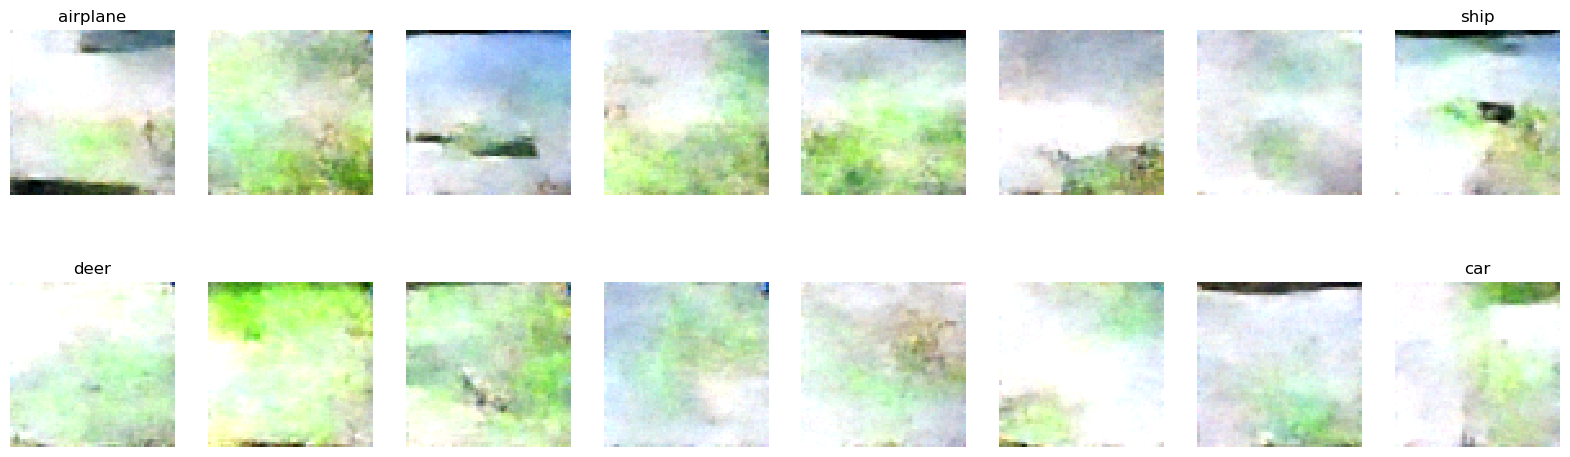

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import gc

gc.collect()
torch.cuda.empty_cache()

try:
    import open_clip
except ImportError:
    print("Please install open_clip: pip install open_clip_torch")
    exit()

CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 16,
    "lr": 2e-4,
    "epochs": 100,
    "img_size": 64,
    "timesteps": 500,
    "embed_dim": 512,
    "output_dir": "stl10_diffusion_outputs"
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)
print(f"Running Final Corrected Diffusion on {CONFIG['device']}...")

def get_stl10_loader():
    transform = T.Compose([
        T.Resize(CONFIG['img_size']),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    download = not os.path.exists('./data/stl10_binary')
    dataset = datasets.STL10(root='./data', split='train', download=download, transform=transform)
    loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True)
    return loader, dataset

class DiffusionScheduler:
    def __init__(self, timesteps=500, start=0.0001, end=0.02, device="cpu"):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(start, end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat)

    def noise_images(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t][:, None, None, None]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t][:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.timesteps, size=(n,)).to(self.device)

class CLIPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        print("Loading CLIP (Visual Only)...")
        full_model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device='cpu')

        self.visual = full_model.visual
        self.visual.eval()

        del full_model
        gc.collect()
        torch.cuda.empty_cache()

        self.register_buffer("mean", torch.tensor([0.481, 0.457, 0.408]).view(1,3,1,1))
        self.register_buffer("std", torch.tensor([0.268, 0.261, 0.275]).view(1,3,1,1))

    @torch.no_grad()
    def forward(self, images):
        x = (images + 1) * 0.5
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = (x - self.mean) / self.std
        features = self.visual(x)
        return features.float() / features.norm(dim=-1, keepdim=True)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bn1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bn2(self.relu(self.conv2(h)))
        return h

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256) #Architecture: 64 -> 128 -> 256 -> Bottleneck -> 256 -> 128 -> 64
        up_channels = (256, 128, 64)
        time_emb_dim = 128
        clip_emb_dim = 512

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.clip_proj = nn.Sequential(
            nn.Linear(clip_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.inc = Block(image_channels, 64, time_emb_dim)

        self.down1 = Block(64, 128, time_emb_dim)
        self.down2 = Block(128, 256, time_emb_dim)

        self.pool = nn.MaxPool2d(2)

        self.bot1 = Block(256, 256, time_emb_dim)
        self.bot2 = Block(256, 256, time_emb_dim)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up_block1 = Block(128 + 256, 128, time_emb_dim) #128 from up + 256 from skip

        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up_block2 = Block(64 + 128, 64, time_emb_dim) #64 from up + 128 from skip

        self.up3 = nn.ConvTranspose2d(64, 64, 2, 2)
        self.up_block3 = Block(64 + 64, 64, time_emb_dim) #64 from up + 64 from initial

        self.outc = nn.Conv2d(64, 3, 1)

    def forward(self, x, timestep, clip_emb):
        t = self.time_mlp(timestep)
        c = self.clip_proj(clip_emb)
        t = t + c

        #Encoder
        x1 = self.inc(x, t) #64x64, 64ch

        x2 = self.pool(x1) #32x32
        x2 = self.down1(x2, t) #32x32, 128ch

        x3 = self.pool(x2) #16x16
        x3 = self.down2(x3, t) #16x16, 256ch

        x4 = self.pool(x3) #8x8

        #BottleNeck
        x4 = self.bot1(x4, t)
        x4 = self.bot2(x4, t) #8x8, 256ch

        #Decoder
        #Up 1 (8 -> 16)
        x = self.up1(x4)#16x16, 128ch
        x = torch.cat([x, x3], dim=1)
        x = self.up_block1(x, t)#16x16, 128ch

        #Up 2 (16 -> 32)
        x = self.up2(x)#32x32, 64ch
        x = torch.cat([x, x2], dim=1)
        x = self.up_block2(x, t)#32x32, 64ch

        #Up 3 (32 -> 64)
        x = self.up3(x) #64x64, 64ch
        x = torch.cat([x, x1], dim=1)
        x = self.up_block3(x, t) #64x64, 64ch

        return self.outc(x)

def train_diffusion():
    loader, dataset = get_stl10_loader()

    encoder = CLIPEncoder().to(CONFIG['device'])
    model = SimpleUNet().to(CONFIG['device'])

    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    mse = nn.MSELoss()
    diffusion = DiffusionScheduler(timesteps=CONFIG['timesteps'], device=CONFIG['device'])

    print(f"Starting Diffusion Training on {len(dataset)} images...")

    scaler = torch.cuda.amp.GradScaler() if CONFIG['device'] == 'cuda' else None

    for epoch in range(CONFIG['epochs']):
        model.train()
        total_loss = 0

        for i, (images, _) in enumerate(loader):
            images = images.to(CONFIG['device'])
            t = diffusion.sample_timesteps(images.shape[0])
            x_t, noise = diffusion.noise_images(images, t)

            with torch.no_grad():
                clip_emb = encoder(images)

            optimizer.zero_grad()

            if CONFIG['device'] == 'cuda':
                with torch.cuda.amp.autocast():
                    predicted_noise = model(x_t, t, clip_emb)
                    loss = mse(noise, predicted_noise)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                predicted_noise = model(x_t, t, clip_emb)
                loss = mse(noise, predicted_noise)
                loss.backward()
                optimizer.step()

            total_loss += loss.item()

            if i % 50 == 0:
                print(f"Epoch {epoch+1} | Batch {i} | Loss: {loss.item():.4f}")

        print(f"Epoch {epoch+1} Avg Loss: {total_loss/len(loader):.4f}")

    return encoder, model, diffusion, dataset

def sample(model, diffusion, clip_emb):
    model.eval()
    n = clip_emb.shape[0]
    x = torch.randn((n, 3, CONFIG['img_size'], CONFIG['img_size'])).to(CONFIG['device'])

    with torch.no_grad():
        for i in reversed(range(1, diffusion.timesteps)):
            t = (torch.ones(n) * i).long().to(CONFIG['device'])
            predicted_noise = model(x, t, clip_emb)

            alpha = diffusion.alphas[t][:, None, None, None]
            alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
            beta = diffusion.betas[t][:, None, None, None]

            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

    x = (x.clamp(-1, 1) + 1) / 2
    return x.cpu().permute(0, 2, 3, 1).numpy()

def visualize_diffusion_blends(encoder, model, diffusion, dataset):
    print("Generating Diffusion Blends...")
    class_map = {0: 'airplane', 8: 'ship', 4: 'deer', 2: 'car'}
    examples = {}
    indices = np.random.permutation(len(dataset))
    for idx in indices:
        img, label = dataset[idx]
        if label not in examples: examples[label] = img
        if len(examples) == 10: break

    pairs = [(0, 8), (4, 2)]
    steps = 8

    fig, axes = plt.subplots(len(pairs), steps, figsize=(20, 3 * len(pairs)))

    with torch.no_grad():
        for row, (c1, c2) in enumerate(pairs):
            img1 = examples[c1].unsqueeze(0).to(CONFIG['device'])
            img2 = examples[c2].unsqueeze(0).to(CONFIG['device'])

            emb1 = encoder(img1)
            emb2 = encoder(img2)

            alphas = np.linspace(0, 1, steps)

            for col, alpha in enumerate(alphas):
                theta = torch.acos(torch.sum(emb1 * emb2))
                sin_theta = torch.sin(theta)
                if sin_theta < 1e-6:
                     mixed_emb = (1-alpha)*emb1 + alpha*emb2
                else:
                    w1 = torch.sin((1-alpha)*theta)/sin_theta
                    w2 = torch.sin(alpha*theta)/sin_theta
                    mixed_emb = w1*emb1 + w2*emb2

                generated_img = sample(model, diffusion, mixed_emb)

                ax = axes[row, col]
                ax.imshow(generated_img[0])
                ax.axis('off')

                if col == 0: ax.set_title(class_map.get(c1, ''))
                if col == steps - 1: ax.set_title(class_map.get(c2, ''))

    save_path = f"{CONFIG['output_dir']}/diffusion_blends.png"
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Saved to {save_path}")

if __name__ == "__main__":
    enc, model, diff, ds = train_diffusion()
    visualize_diffusion_blends(enc, model, diff, ds)

**Method**:
Diffusion-based image generation with conditioning on CLIP embeddings

**Model Used**:
UNet-based Diffusion Model with CLIP embeddings

**Model Type**:
Conditional Diffusion Model (UNet with CLIP Encoder)

**Model Input**:
Images (STL10 dataset): Selected images (e.g., Car, Ship) from the dataset.

**CLIP Embedding:** Embedding vector representing the target image's features.

**Generation Mode:**
Conditional denoising diffusion: Starts with noise, progressively denoises towards a target image based on the CLIP embedding.

**Optimizer**:
AdamW

**Learning Rate:**
2e-4

**Loss Function:**
Mean Squared Error (MSE) between predicted and actual noise at each timestep.


This is the output for this model:
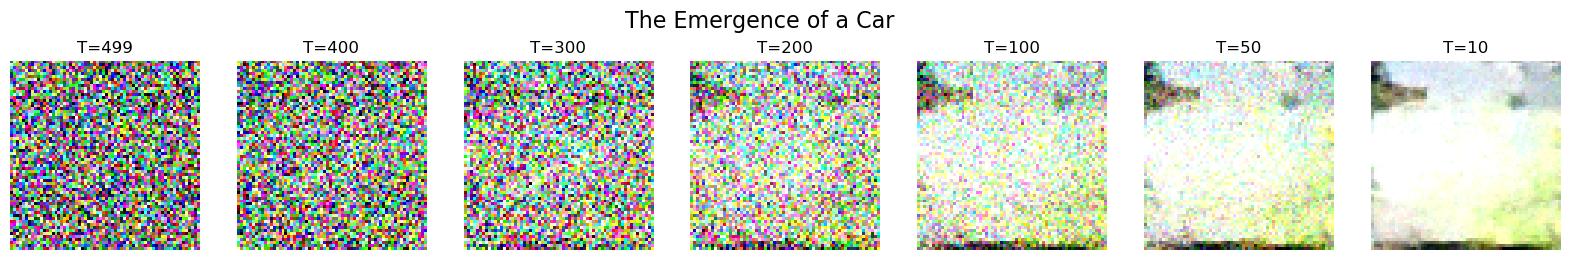

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

if 'model' in globals():
    torch.save(model.state_dict(), "stl10_diffusion_v2.pth")
    print(" Model saved to stl10_diffusion_v2.pth")
else:
    print(" Model not found in memory. Did you restart the kernel?")

def sample_history(model, diffusion, clip_emb):
    model.eval()
    n = clip_emb.shape[0]
    x = torch.randn((n, 3, 64, 64)).to(CONFIG['device'])

    capture_steps = [499, 400, 300, 200, 100, 50, 10, 0]
    history = []

    with torch.no_grad():
        for i in reversed(range(1, diffusion.timesteps)):
            t = (torch.ones(n) * i).long().to(CONFIG['device'])
            predicted_noise = model(x, t, clip_emb)

            alpha = diffusion.alphas[t][:, None, None, None]
            alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
            beta = diffusion.betas[t][:, None, None, None]

            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

            if i in capture_steps:
                img = (x.clamp(-1, 1) + 1) / 2
                img = img.cpu().permute(0, 2, 3, 1).numpy()[0]
                history.append((i, img))

    return history

def visualize_emergence(encoder, model, diffusion, dataset):
    print("Visualizing emergence (Timeline of creation)...")

    targets = {2: 'Car', 8: 'Ship'}

    for cls_idx, name in targets.items():
        target_img = None
        for img, label in dataset:
            if label == cls_idx:
                target_img = img.unsqueeze(0).to(CONFIG['device'])
                break

        with torch.no_grad():
            emb = encoder(target_img)

        steps = sample_history(model, diffusion, emb)

        fig, axes = plt.subplots(1, len(steps), figsize=(20, 3))
        fig.suptitle(f"The Emergence of a {name}", fontsize=16)

        for idx, (t, img) in enumerate(steps):
            axes[idx].imshow(img)
            axes[idx].set_title(f"T={t}")
            axes[idx].axis('off')

        plt.show()

if 'model' in globals():
    visualize_emergence(enc, model, diff, ds)

**Method:**
Diffusion-based image generation with conditioning on CLIP embeddings

**Model Used:**
UNet-based Diffusion Model with CLIP embeddings

**Model Type:**
Conditional Diffusion Model (UNet with CLIP Encoder)

**Model Input:**
Images (STL10 dataset): Images selected from the STL10 dataset


**Loss Function:**
MSELoss (Mean Squared Error between predicted noise and actual noise)

**Activation Function:**
ReLU (Rectified Linear Unit, used in the hidden layers)

**Output Directory:**
"stl10_diffusion_outputs"


This is the output for this model:
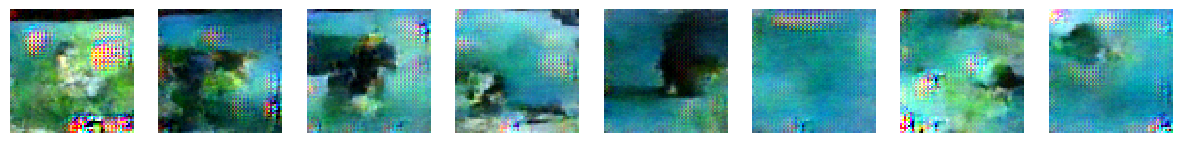

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import gc

gc.collect()
torch.cuda.empty_cache()

CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 16,
    "lr": 2e-4,
    "epochs": 100,
    "img_size": 64,
    "timesteps": 500,
    "embed_dim": 512,
    "output_dir": "stl10_diffusion_outputs"
}
os.makedirs(CONFIG["output_dir"], exist_ok=True)

try:
    import open_clip
except ImportError:
    print("Please install open_clip: pip install open_clip_torch")

class CLIPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        full_model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device='cpu')
        self.visual = full_model.visual
        self.visual.eval()
        del full_model
        gc.collect()

        self.register_buffer("mean", torch.tensor([0.481, 0.457, 0.408]).view(1,3,1,1))
        self.register_buffer("std", torch.tensor([0.268, 0.261, 0.275]).view(1,3,1,1))

    @torch.no_grad()
    def forward(self, images):
        x = (images + 1) * 0.5
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = (x - self.mean) / self.std
        features = self.visual(x)
        return features.float() / features.norm(dim=-1, keepdim=True)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bn1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bn2(self.relu(self.conv2(h)))
        return h

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        time_emb_dim = 128

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.clip_proj = nn.Sequential(
            nn.Linear(512, time_emb_dim),
            nn.ReLU()
        )

        self.inc = Block(3, 64, time_emb_dim) #64
        self.down1 = Block(64, 128, time_emb_dim) #32
        self.down2 = Block(128, 256, time_emb_dim) #16

        self.pool = nn.MaxPool2d(2)

        self.bot1 = Block(256, 256, time_emb_dim)
        self.bot2 = Block(256, 256, time_emb_dim)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up_block1 = Block(128 + 256, 128, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up_block2 = Block(64 + 128, 64, time_emb_dim)

        self.up3 = nn.ConvTranspose2d(64, 64, 2, 2)
        self.up_block3 = Block(64 + 64, 64, time_emb_dim)

        self.outc = nn.Conv2d(64, 3, 1)

    def forward(self, x, timestep, clip_emb):
        t = self.time_mlp(timestep) + self.clip_proj(clip_emb)

        #DOWN
        x1 = self.inc(x, t) #64x64
        x2 = self.down1(self.pool(x1), t) #32x32
        x3 = self.down2(self.pool(x2), t) #16x16
        x4 = self.pool(x3) #8x8

        #BOTTLENECK
        x4 = self.bot1(x4, t)
        x4 = self.bot2(x4, t) #8x8

        #UP
        #8->16
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.up_block1(x, t)

        #16->32
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up_block2(x, t)

        #32->64
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up_block3(x, t)

        return self.outc(x)

class DiffusionScheduler:
    def __init__(self, timesteps=500, device="cpu"):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(0.0001, 0.02, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat)

    def noise_images(self, x, t):
        sqrt_alpha = self.sqrt_alpha_hat[t][:, None, None, None]
        sqrt_one_minus = self.sqrt_one_minus_alpha_hat[t][:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha * x + sqrt_one_minus * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.timesteps, size=(n,)).to(self.device)

def train_and_viz():
    transform = T.Compose([T.Resize(64), T.ToTensor(), T.Normalize((0.5,),(0.5,))])
    dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
    loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True)

    encoder = CLIPEncoder().to(CONFIG['device'])
    model = SimpleUNet().to(CONFIG['device'])
    opt = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    mse = nn.MSELoss()
    diff = DiffusionScheduler(timesteps=CONFIG['timesteps'], device=CONFIG['device'])
    scaler = torch.cuda.amp.GradScaler()

    print("Starting Training...")

    for epoch in range(CONFIG['epochs']):
        model.train()
        total_loss = 0
        for i, (images, _) in enumerate(loader):
            images = images.to(CONFIG['device'])
            t = diff.sample_timesteps(images.shape[0])
            x_t, noise = diff.noise_images(images, t)

            with torch.no_grad():
                clip_emb = encoder(images)

            opt.zero_grad()
            with torch.cuda.amp.autocast():
                pred_noise = model(x_t, t, clip_emb)
                loss = mse(noise, pred_noise)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            total_loss += loss.item()
            if i % 50 == 0: print(f"Ep {epoch+1} Batch {i} Loss: {loss.item():.4f}")

    print("Training Complete. Generating Blends...")

    model.eval()

    car = next(img for img, l in dataset if l == 2).unsqueeze(0).to(CONFIG['device'])
    ship = next(img for img, l in dataset if l == 8).unsqueeze(0).to(CONFIG['device'])

    with torch.no_grad():
        emb1 = encoder(car)
        emb2 = encoder(ship)

        steps = 8
        alphas = np.linspace(0, 1, steps)
        fig, axes = plt.subplots(1, steps, figsize=(15, 3))

        for i, alpha in enumerate(alphas):
            mixed = (1-alpha)*emb1 + alpha*emb2

            x = torch.randn((1, 3, 64, 64)).to(CONFIG['device'])
            for t_idx in reversed(range(1, diff.timesteps)):
                t = (torch.ones(1) * t_idx).long().to(CONFIG['device'])
                pred = model(x, t, mixed)

                a = diff.alphas[t][:, None, None, None]
                a_hat = diff.alpha_hat[t][:, None, None, None]
                b = diff.betas[t][:, None, None, None]
                noise = torch.randn_like(x) if t_idx > 1 else 0

                x = 1/torch.sqrt(a) * (x - ((1-a)/torch.sqrt(1-a_hat))*pred) + torch.sqrt(b)*noise

            img = (x.clamp(-1, 1) + 1) / 2
            axes[i].imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())
            axes[i].axis('off')

    plt.savefig(f"{CONFIG['output_dir']}/final_blends.png")
    print("Saved blends.")

if __name__ == "__main__":
    train_and_viz()

**Method:**
Diffusion-based image generation with conditioning on CLIP embeddings

**Model Used:**
UNet-based Diffusion Model with CLIP embeddings

**Model Type:**
Conditional Diffusion Model (UNet with CLIP Encoder)

**Model Input:**
Images (STL10 dataset): Images selected from the STL10 dataset (e.g., Car (class 2), Ship (class 8)).

**CLIP Embedding:** Embedding vector representing the target image's features.

**Dataset Size:**

STL10 dataset: 13,000 labeled images (5,000 for training and 8,000 for test).


**Loss Function:**
MSELoss (Mean Squared Error between predicted noise and actual noise)

**Activation Function:**
ReLU (Rectified Linear Unit, used in the hidden layers)

**Output Directory:**
"stl10_diffusion_outputs"

This is the output for this model:
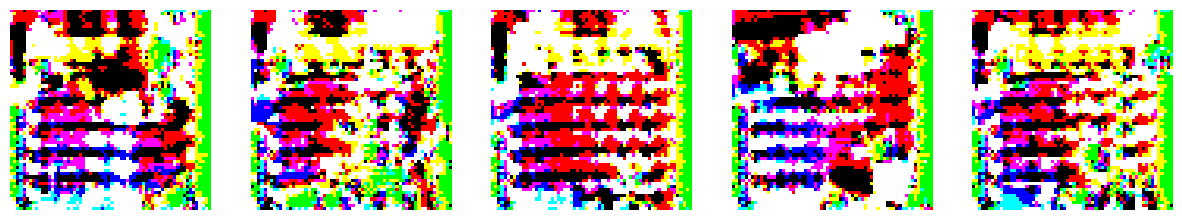

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import gc

gc.collect()
torch.cuda.empty_cache()

CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 16,
    "lr": 2e-4,
    "epochs": 100,
    "img_size": 64,
    "timesteps": 500,
    "embed_dim": 512,
    "output_dir": "stl10_diffusion_outputs"
}
os.makedirs(CONFIG["output_dir"], exist_ok=True)

try:
    import open_clip
except ImportError:
    print("Please install open_clip: pip install open_clip_torch")

class CLIPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        full_model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device='cpu')
        self.visual = full_model.visual
        self.visual.eval()
        del full_model
        gc.collect()
        self.register_buffer("mean", torch.tensor([0.481, 0.457, 0.408]).view(1,3,1,1))
        self.register_buffer("std", torch.tensor([0.268, 0.261, 0.275]).view(1,3,1,1))

    @torch.no_grad()
    def forward(self, images):
        x = (images + 1) * 0.5
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = (x - self.mean) / self.std
        features = self.visual(x)
        return features.float() / features.norm(dim=-1, keepdim=True)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
    def forward(self, x, t):
        h = self.bn1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bn2(self.relu(self.conv2(h)))
        return h

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        time_emb_dim = 128
        self.time_mlp = nn.Sequential(SinusoidalPositionEmbeddings(time_emb_dim), nn.Linear(time_emb_dim, time_emb_dim), nn.ReLU())
        self.clip_proj = nn.Sequential(nn.Linear(512, time_emb_dim), nn.ReLU())

        self.inc = Block(3, 64, time_emb_dim)
        self.down1 = Block(64, 128, time_emb_dim)
        self.down2 = Block(128, 256, time_emb_dim)
        self.pool = nn.MaxPool2d(2)

        self.bot1 = Block(256, 256, time_emb_dim)
        self.bot2 = Block(256, 256, time_emb_dim)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up_block1 = Block(128 + 256, 128, time_emb_dim)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up_block2 = Block(64 + 128, 64, time_emb_dim)
        self.up3 = nn.ConvTranspose2d(64, 64, 2, 2)
        self.up_block3 = Block(64 + 64, 64, time_emb_dim)
        self.outc = nn.Conv2d(64, 3, 1)

    def forward(self, x, timestep, clip_emb):
        t = self.time_mlp(timestep) + self.clip_proj(clip_emb)
        x1 = self.inc(x, t)
        x2 = self.down1(self.pool(x1), t)
        x3 = self.down2(self.pool(x2), t)
        x4 = self.pool(x3)
        x4 = self.bot2(self.bot1(x4, t), t)
        x = self.up_block1(torch.cat([self.up1(x4), x3], dim=1), t)
        x = self.up_block2(torch.cat([self.up2(x), x2], dim=1), t)
        x = self.up_block3(torch.cat([self.up3(x), x1], dim=1), t)
        return self.outc(x)

class DiffusionScheduler:
    def __init__(self, timesteps=500, device="cpu"):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(0.0001, 0.02, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat)

    def noise_images(self, x, t):
        sqrt_alpha = self.sqrt_alpha_hat[t][:, None, None, None]
        sqrt_one_minus = self.sqrt_one_minus_alpha_hat[t][:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha * x + sqrt_one_minus * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.timesteps, size=(n,)).to(self.device)

def run_training_global():
    transform = T.Compose([T.Resize(64), T.ToTensor(), T.Normalize((0.5,),(0.5,))])
    dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
    loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True)

    print("Initializing models...")
    enc = CLIPEncoder().to(CONFIG['device'])
    unet = SimpleUNet().to(CONFIG['device'])
    diff = DiffusionScheduler(timesteps=CONFIG['timesteps'], device=CONFIG['device'])

    opt = optim.AdamW(unet.parameters(), lr=CONFIG['lr'])
    mse = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler()

    print(f"Starting Training ({CONFIG['epochs']} Epochs)...")

    for epoch in range(CONFIG['epochs']):
        unet.train()
        total_loss = 0
        for i, (images, _) in enumerate(loader):
            images = images.to(CONFIG['device'])
            t = diff.sample_timesteps(images.shape[0])
            x_t, noise = diff.noise_images(images, t)

            with torch.no_grad():
                clip_emb = enc(images)

            opt.zero_grad()
            with torch.cuda.amp.autocast():
                pred_noise = unet(x_t, t, clip_emb)
                loss = mse(noise, pred_noise)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            total_loss += loss.item()
            if i % 100 == 0: print(f"Ep {epoch+1} Batch {i} Loss: {loss.item():.4f}")

    print("Saving model to disk...")
    torch.save(unet.state_dict(), "stl10_diffusion_saved.pth")
    print(" Model Saved Successfully.")

    return enc, unet, diff, dataset

if __name__ == "__main__":
    enc, model, diff, ds = run_training_global()

    print("Generating Visualization...")
    model.eval()
    car = next(img for img, l in ds if l == 2).unsqueeze(0).to(CONFIG['device'])
    ship = next(img for img, l in ds if l == 8).unsqueeze(0).to(CONFIG['device'])

    with torch.no_grad():
        emb1 = enc(car)
        emb2 = enc(ship)

        steps = 5
        alphas = np.linspace(0, 1, steps)
        fig, axes = plt.subplots(1, steps, figsize=(15, 3))

        for i, alpha in enumerate(alphas):
            mixed = (1-alpha)*emb1 + alpha*emb2
            x = torch.randn((1, 3, 64, 64)).to(CONFIG['device'])

            for t_idx in reversed(range(1, diff.timesteps)):
                t = (torch.ones(1) * t_idx).long().to(CONFIG['device'])
                pred = model(x, t, mixed)

                a = diff.alphas[t][:, None, None, None]
                a_hat = diff.alpha_hat[t][:, None, None, None]
                b = diff.betas[t][:, None, None, None]
                noise = torch.randn_like(x) if t_idx > 1 else 0

                x = 1/torch.sqrt(a) * (x - ((1-a)/torch.sqrt(1-a_hat))*pred) + torch.sqrt(b)*noise

            img = (x.clamp(-1, 1) + 1) / 2
            axes[i].imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())
            axes[i].axis('off')

    plt.savefig(f"{CONFIG['output_dir']}/final_blends_v4.png")
    print("Blends generated.")